In [1]:
import numpy as np
import pandas as pd
import logging
import pickle
import os 
import matplotlib.pyplot as plt

datadir = "data/"

# 5000 patterns. Each pattern consists of indices characterized by which chnanels are modulated oen of 4 delay modes. 44 stimulating channels are used (though some pattern indices have no stimulation on any channels). 
# Each stim is 3 uA amplitude, biphasic, 167-66-167 us biphasic pulses with 66 us interphase interval. 
# approx 30kHz sampling rate but imprecise. Each index step lasts 0.06s, and 10 pattern steps are present for each pattern.

# Each stimulation is delivered in 600 ms period, with 1400 inter-stimulation interval. Thus, 2 s per stimulation * 5000 stimulations = 10000 seconds total experiment.

pattern_registrations = pickle.load(open(os.path.join(datadir, "pattern_registrations.pkl"), "rb"))

# spkVecs contains spike times for all neurons. 47 are recorded.
spikes_df = pd.DataFrame(np.load(os.path.join(datadir, "spkVecs.npy"))) # size = (3396476,))
spikes_df.columns = ['timestamp', 'neuron_id', 'segment_index']
spikes_df.drop(columns=['segment_index'], inplace=True)
spikes_df['timestamp'] = spikes_df['timestamp'].astype(int)
spikes_df['neuron_id'] = spikes_df['neuron_id'].astype(int) # noncontinuous neuron ids from with numbers corresponding to shank location
spikes_df.sort_values(by=['timestamp', 'neuron_id'], inplace=True)
print (spikes_df.shape)
print (spikes_df['neuron_id'].nunique(), " unique neurons recorded")
print (spikes_df['timestamp'].max()/1000, " seconds of recording")
spikes_df.head(5)

(3396476, 2)
47  unique neurons recorded
328503.754  seconds of recording


,timestamp,neuron_id
0,122,206
1,196,5
2,244,200
3,246,300
4,340,200


In [2]:
import pandas as pd
import numpy as np

def read_pattern_json(data):
    # 1. Flatten the Pattern -> Steps level
    # We use record_path to reach the 'steps' and meta to keep parent info
    df = pd.json_normalize(
        data, 
        record_path=['steps'], 
        meta=[
            'pattern_name', # given name of the pattern
            'pattern_lambda', # given lambda parameter that generated the pattern 
            'pattern_flag_start_timestamp', # given starting timpestamp of pattern
            'pattern_timing_index' # given order of pattern from 1-5,000 (first to last)
        ],
        record_prefix='step_'
    )
    # 2. Flatten the 'step_channel_delays' list into individual rows
    # This creates a row for every delay entry. Steps with [] will become NaN.
    df = df.explode('step_channel_delays').reset_index(drop=True)

    # 3. Convert the dictionaries in 'step_channel_delays' into separate columns
    delays_df = pd.json_normalize(df['step_channel_delays'])
    
    # 4. Store pattern length
    df['pattern_idx_length'] = df.groupby('pattern_timing_index')['step_index'].transform('max') + 1

    # 6. Combine and cleanup
    final_df = pd.concat([df.drop(columns=['step_channel_delays']), delays_df], axis=1)
    
    # 7. Convert timestamps to integers and subtract original timestamp from step timestamps
    final_df['step_start_timestamp'] = final_df['step_start_timestamp'].astype(int)
    final_df['pattern_flag_start_timestamp'] = final_df['pattern_flag_start_timestamp'].astype(int)

    return final_df



In [4]:
pattern_df = read_pattern_json(pattern_registrations)

# define pattern end as pattern's start time - 1
# build unique patterns and set end = next pattern's start - 1
patterns = (pattern_df.groupby(['pattern_timing_index', 'pattern_name'])['pattern_flag_start_timestamp']
            .first().reset_index())
patterns = patterns.sort_values('pattern_timing_index').reset_index(drop=True)

# last spike time for final end
last_spike_time = spikes_df['timestamp'].max()

# end = next start - 1
patterns['pattern_end_timestamp'] = patterns['pattern_flag_start_timestamp'].shift(-1) - 1
patterns['pattern_end_timestamp'].iloc[-1] = last_spike_time

# ensure integer timestamps
patterns['pattern_end_timestamp'] = patterns['pattern_end_timestamp'].astype(int)
patterns['pattern_flag_start_timestamp'] = patterns['pattern_flag_start_timestamp'].astype(int)

# merge end times back into the full step-level dataframe
pattern_df = pattern_df.merge(
    patterns[['pattern_timing_index', 'pattern_end_timestamp']],
    on='pattern_timing_index',
    how='left'
)

# how many times each pattern appears in separate timestamps
pattern_counts = pattern_df[['pattern_name', 'pattern_timing_index']].drop_duplicates().groupby('pattern_name').size()
min_pattern_timestamp = pattern_df['pattern_flag_start_timestamp'].min()
# Center times to 0 for easier intepretation
pattern_df['pattern_flag_start_timestamp'] -= min_pattern_timestamp
pattern_df['pattern_end_timestamp'] -= min_pattern_timestamp
pattern_df['pattern_duration'] = pattern_df['pattern_end_timestamp'] - pattern_df['pattern_flag_start_timestamp']
pattern_df['step_start_timestamp'] -= min_pattern_timestamp
spikes_df['timestamp'] -= min_pattern_timestamp
pattern_df.head(30)

/var/folders/38/_qz39whn0hngmtsmjg9byfbr0000gn/T/ipykernel_24765/624276988.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  patterns['pattern_end_timestamp'].iloc[-1] = last_spike_time
/var/folders/38/_qz39whn0hngmtsmjg9byfbr0000gn/T/ipy

,step_index,step_start_timestamp,pattern_name,pattern_lambda,pattern_flag_start_timestamp,pattern_timing_index,pattern_idx_length,channel,delay_mode,pattern_end_timestamp,pattern_duration
0,0,3891,2961,0.8,0,0,10,NaN,NaN,62201,62201
1,1,5691,2961,0.8,0,0,10,NaN,NaN,62201,62201
2,2,7491,2961,0.8,0,0,10,17.0,1.0,62201,62201
3,2,7491,2961,0.8,0,0,10,79.0,0.0,62201,62201
4,3,9771,2961,0.8,0,0,10,23.0,1.0,62201,62201
5,3,9771,2961,0.8,0,0,10,36.0,0.0,62201,62201
6,4,11718,2961,0.8,0,0,10,37.0,-1.0,62201,62201
7,4,11718,2961,0.8,0,0,10,57.0,0.0,62201,62201
8,5,13628,2961,0.8,0,0,10,24.0,0.0,62201,62201
9,5,13628,2961,0.8,0,0,10,63.0,0.0,62201,62201


In [ ]:
channel_to_index = {ch: idx for idx, ch in enumerate(sorted(pattern_df['channel'].dropna().unique()))}
print ("Channel indices to channel mapping:")
for ch, idx in channel_to_index.items():
    print (f"Channel {ch}: index {idx}")

spiking_neurons = spikes_df['neuron_id'].unique()
spiking_neurons.sort()
print (f"Total spiking neurons recorded: {len(spiking_neurons)}")
print ("Spiking neuron names: ", spiking_neurons)
spiking_neuron_to_index = {neuron: idx for idx, neuron in enumerate(spiking_neurons)}
print ("Spiking neuron to index mapping:")
for neuron, idx in spiking_neuron_to_index.items():
    print (f"Spiking neuron {neuron}: index {idx}")


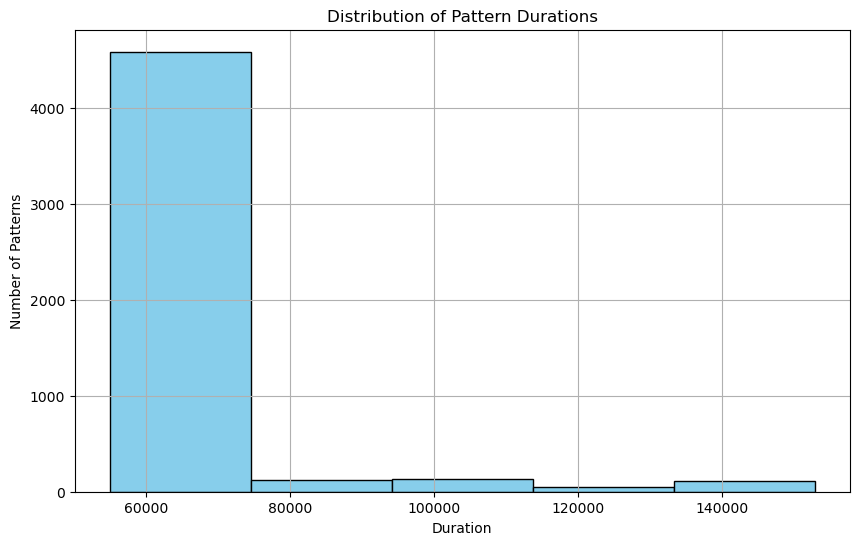

count      5000.000000
mean      65519.348200
std       15338.105629
min       55014.000000
25%       61231.000000
50%       61304.000000
75%       61411.000000
max      152841.000000
Name: pattern_duration, dtype: float64
472  outliers with duration > 65000


In [29]:
# Pattern duration plot
pattern_durations = pattern_df.groupby(['pattern_name']).first()['pattern_duration']
plt.figure(figsize=(10, 6))
plt.hist(pattern_durations, bins=5, color='skyblue', edgecolor='black')
plt.title('Distribution of Pattern Durations')
plt.xlabel('Duration')
plt.ylabel('Number of Patterns')
plt.grid()
plt.show()
print (pattern_durations.describe())
print (pattern_durations[pattern_durations > 65000].shape[0], " outliers with duration > 65000")

In [ ]:
# Calculate firing rate distribution over patterns per neuron (mean and SD)
seen_patterns = {}
firing_rates = {}
for neuron_id in spikes_df['neuron_id'].unique():
    neuron_spikes = spikes_df[spikes_df['neuron_id'] == neuron_id]
    rates = []
    for idx, row in pattern_df.iterrows():
        if row['pattern_name'] in seen_patterns:
            continue # quick and dirty
        t_start = row['pattern_flag_start_timestamp']
        t_end = row['pattern_end_timestamp']
        count = neuron_spikes[(neuron_spikes['timestamp'] >= t_start) & (neuron_spikes['timestamp'] < t_end)].shape[0]
        duration_sec = (t_end - t_start) / 30000  # Convert ticks to seconds
        rate = count / duration_sec if duration_sec > 0 else 0
        rates.append(rate)
        seen_patterns[row['pattern_name']] = True
    firing_rates[neuron_id] = {
        'mean_rate': np.mean(rates),
        'std_rate': np.std(rates)
    }
# firing_rates_df = pd.DataFrame.from_dict(firing_rates, orient='index')
# firing_rates_df.columns = ['mean_firing_rate', 'std_firing_rate']

# make a violin plot for each neuron of firing rates across patterns
# plt.figure(figsize=(12, 6))
# plt.violinplot([spikes_df[spikes_df['neuron_id'] == nid]['timestamp'].groupby(
#     pd.cut(spikes_df[spikes_df['neuron_id'] == nid]['timestamp'], bins=patterns['pattern_flag_start_timestamp'].tolist() + [last_spike_time])
# ).count() / ((patterns['pattern_end_timestamp'] - patterns['pattern_flag_start_timestamp']).values / 30000) for nid in spikes_df['neuron_id'].unique()],
#                showmeans=True)
# plt.xticks(ticks=np.arange(1, len(spikes_df['neuron_id'].unique()) + 1), labels=spikes_df['neuron_id'].unique(), rotation=90)
# plt.xlabel('Neuron ID')
# plt.ylabel('Firing Rate (spikes/sec)')
# plt.title('Firing Rate Distribution Across Patterns per Neuron')
# plt.tight_layout()
# plt.savefig('patterns_data_firing_rate_distribution_per_neuron.png')
# plt.show()



In [ ]:
# Inputs: 600 ms (10 0.6ms steps) x 44 stimulating channels with 4 delay modes.
pattern_stims = {}
spike_responses = {}
for pattern_name in pattern_df['pattern_name'].unique():
    pattern_subset = pattern_df[pattern_df['pattern_name'] == pattern_name]
    pattern_start_time = pattern_subset['pattern_flag_start_timestamp'].iloc[0]
    pattern_end_time = pattern_subset['pattern_end_timestamp'].iloc[0]
    stim = np.zeros((44, 600))  # 44 channels, 600 ms duration
    for idx, row in pattern_subset.iterrows(): # process each substep
        step_index = row['step_index']
        stim_ms = 60 * step_index  # each step is 60 ms
        if pd.isna(row['channel']):
            continue  # No stimulation for this step
        channel_index = channel_to_index[int(row['channel'])]
        delay_mode = int(row['delay_mode'])
        # TODO: Map delay modes to phase structures and timings
        if delay_mode == 0: # 3 pulses, 50 Hz, starting at stim_ms
            for pulse in range(3):
                pulse_time = stim_ms + pulse * 20  # 20 ms interval for 50 Hz
                if pulse_time < 600:
                    stim[channel_index, pulse_time] = 3 # 3 uA amplitude
        elif delay_mode == 1: # 3 pulses, 50 Hz, starting at 10ms after stim_ms
            for pulse in range(3):
                pulse_time = stim_ms + 10 + pulse * 20  # 20 ms interval for 50 Hz
                if pulse_time < 600:
                    stim[channel_index, pulse_time] = 3 # 3 uA amplitude
        elif delay_mode == -1: # same as 0 but with reverse phase structure
            for pulse in range(3): 
                pulse_time = stim_ms + pulse * 20  # 20 ms interval for 50 Hz
                if pulse_time < 600:
                    stim[channel_index, pulse_time] = 3 # 3 uA amplitude
        elif delay_mode == 2: # 6 pulses, 100 Hz, starting at stim_ms
            for pulse in range(6):
                pulse_time = stim_ms + pulse * 10  # 10 ms interval for 100 Hz
                if pulse_time < 600:
                    stim[channel_index, pulse_time] = 3 # 3 uA amplitude
    pattern_stims[pattern_name] = stim
    spikes_during_pattern = spikes_df[(spikes_df['timestamp'] >= pattern_start_time) & (spikes_df['timestamp'] < pattern_end_time)]
    spike_responses_pattern = np.zeros((len(spiking_neurons), 2000))
    for idx, row in spikes_during_pattern.iterrows():
        neuron_id = row['neuron_id']
        neuron_index = spiking_neuron_to_index[neuron_id]
        spike_time = row['timestamp'] - pattern_start_time  # relative to pattern start
        if 0 <= spike_time < 2000:
            spike_responses_pattern[neuron_index, spike_time] = 1
    spike_responses[pattern_name] = spike_responses_pattern
    

# Example: Plot stimulation pattern for a specific pattern
for pattern_name in list(pattern_stims.keys())[:1]:  # just plot first pattern
    stim = pattern_stims[pattern_name]
    # Plot the stimulation pattern as a heatmap
    plt.figure(figsize=(10, 6)) 
    plt.imshow(stim, aspect='auto', cmap='hot', interpolation='nearest')
    plt.colorbar(label='Stimulation Amplitude (uA)')
    plt.xlabel('Time (ms)')
    plt.ylabel('Channel Index')
    plt.title(f'Stimulation Pattern: {pattern_name}')
    plt.tight_layout()
    plt.show()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split

# =====================
# PyTorch Dataset
# =====================
class StimSpikeDataset(Dataset):
    """
    Dataset for stimulation patterns and spike responses.
    
    Inputs (X): Stimulation patterns of shape (44, 600) - 44 channels x 600 ms
    Outputs (Y): Spike responses of shape (47, 2000) - 47 neurons x 2000 time bins
    """
    def __init__(self, pattern_stims, spike_responses, pattern_names=None):
        """
        Args:
            pattern_stims: dict mapping pattern_name -> (44, 600) numpy array
            spike_responses: dict mapping pattern_name -> (47, 2000) numpy array
            pattern_names: list of pattern names to include (for train/val/test splits)
        """
        if pattern_names is None:
            pattern_names = list(pattern_stims.keys())
        
        self.pattern_names = pattern_names
        self.X = []
        self.Y = []
        
        for name in pattern_names:
            self.X.append(torch.tensor(pattern_stims[name], dtype=torch.float32))
            self.Y.append(torch.tensor(spike_responses[name], dtype=torch.float32))
        
        self.X = torch.stack(self.X)  # (N, 44, 600)
        self.Y = torch.stack(self.Y)  # (N, 47, 2000)
        
    def __len__(self):
        return len(self.pattern_names)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# =====================
# Create Train/Val/Test Splits
# =====================
all_pattern_names = list(pattern_stims.keys())
print(f"Total patterns: {len(all_pattern_names)}")

# Split: 70% train, 15% val, 15% test
train_names, temp_names = train_test_split(all_pattern_names, test_size=0.3, random_state=42)
val_names, test_names = train_test_split(temp_names, test_size=0.5, random_state=42)

print(f"Train: {len(train_names)}, Val: {len(val_names)}, Test: {len(test_names)}")

# Create datasets
train_dataset = StimSpikeDataset(pattern_stims, spike_responses, train_names)
val_dataset = StimSpikeDataset(pattern_stims, spike_responses, val_names)
test_dataset = StimSpikeDataset(pattern_stims, spike_responses, test_names)

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

In [ ]:
# =====================
# RNN Model
# =====================
class StimToSpikeRNN(nn.Module):
    """
    RNN model that maps stimulation patterns to spike responses.
    
    Input: (batch, 44 channels, 600 time steps) -> transpose to (batch, 600, 44)
    Output: (batch, 47 neurons, 2000 time steps)
    """
    def __init__(self, 
                 n_stim_channels=44, 
                 n_neurons=47,
                 hidden_size=128,
                 num_layers=2,
                 dropout=0.2,
                 bidirectional=False):
        super().__init__()
        
        self.n_stim_channels = n_stim_channels
        self.n_neurons = n_neurons
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        # RNN processes time steps of stimulation
        self.rnn = nn.GRU(
            input_size=n_stim_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        rnn_output_size = hidden_size * (2 if bidirectional else 1)
        
        # Project RNN output to spike prediction space
        # We need to go from 600 time steps -> 2000 time steps
        self.temporal_upsample = nn.Sequential(
            nn.Linear(rnn_output_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        
        # Upsample temporally: 600 -> 2000
        self.time_project = nn.Linear(600, 2000)
        
        # Final projection to neurons
        self.output_layer = nn.Sequential(
            nn.Linear(256, n_neurons),
            nn.Sigmoid()  # Spike probabilities
        )
        
    def forward(self, x):
        """
        Args:
            x: (batch, 44, 600) - stimulation patterns
        Returns:
            y: (batch, 47, 2000) - predicted spike responses
        """
        batch_size = x.shape[0]
        
        # Transpose to (batch, time, channels) for RNN
        x = x.permute(0, 2, 1)  # (batch, 600, 44)
        
        # Pass through RNN
        rnn_out, _ = self.rnn(x)  # (batch, 600, hidden_size)
        
        # Project hidden states
        projected = self.temporal_upsample(rnn_out)  # (batch, 600, 256)
        
        # Transpose and upsample time: 600 -> 2000
        projected = projected.permute(0, 2, 1)  # (batch, 256, 600)
        projected = self.time_project(projected)  # (batch, 256, 2000)
        projected = projected.permute(0, 2, 1)  # (batch, 2000, 256)
        
        # Project to neurons
        output = self.output_layer(projected)  # (batch, 2000, 47)
        
        # Transpose to match target shape
        output = output.permute(0, 2, 1)  # (batch, 47, 2000)
        
        return output

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

model = StimToSpikeRNN(
    n_stim_channels=44,
    n_neurons=47,
    hidden_size=128,
    num_layers=1
    dropout=0.2,
    bidirectional=False
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test forward pass
sample_x, sample_y = next(iter(train_loader))
sample_x = sample_x.to(device)
with torch.no_grad():
    sample_out = model(sample_x)
print(f"Input shape: {sample_x.shape}")
print(f"Output shape: {sample_out.shape}")
print(f"Target shape: {sample_y.shape}")

In [ ]:
# =====================
# Training Loop
# =====================
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_x, batch_y in loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_x.size(0)
    
    return total_loss / len(loader.dataset)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            predictions = model(batch_x)
            loss = criterion(predictions, batch_y)
            total_loss += loss.item() * batch_x.size(0)
    
    return total_loss / len(loader.dataset)

# Training configuration
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5

# Loss function - BCE since spike responses are binary
criterion = nn.BCELoss()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'lr': []
}

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
PATIENCE = 10

print("Starting training...")
print("=" * 50)

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Record history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    # Print progress
    print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.6f} | "
          f"Val Loss: {val_loss:.6f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_stim_spike_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print("=" * 50)
print(f"Training complete! Best validation loss: {best_val_loss:.6f}")

In [ ]:
# =====================
# Plot Training History
# =====================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (BCE)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Learning rate
axes[1].plot(history['lr'], color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].set_yscale('log')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

In [ ]:
# =====================
# Evaluate on Test Set
# =====================
# Load best model
model.load_state_dict(torch.load('best_stim_spike_model.pt'))

test_loss = validate(model, test_loader, criterion, device)
print(f"Test Loss (BCE): {test_loss:.6f}")

# Generate predictions on test set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        preds = model(batch_x)
        all_preds.append(preds.cpu())
        all_targets.append(batch_y)

all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

print(f"Test predictions shape: {all_preds.shape}")
print(f"Test targets shape: {all_targets.shape}")

# Visualize a sample prediction vs ground truth
sample_idx = 0
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Ground truth
im0 = axes[0].imshow(all_targets[sample_idx].numpy(), aspect='auto', cmap='hot', interpolation='nearest')
axes[0].set_title(f'Ground Truth Spike Response (Test Sample {sample_idx})')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Neuron Index')
plt.colorbar(im0, ax=axes[0], label='Spike')

# Prediction
im1 = axes[1].imshow(all_preds[sample_idx].numpy(), aspect='auto', cmap='hot', interpolation='nearest')
axes[1].set_title(f'Predicted Spike Response (Test Sample {sample_idx})')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Neuron Index')
plt.colorbar(im1, ax=axes[1], label='Spike Probability')

plt.tight_layout()
plt.savefig('test_prediction_comparison.png', dpi=150)
plt.show()